## Imports and Helper Functions 

In [12]:
import pandas as pd
import numpy as np
import ast # For safely evaluating string-formatted lists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import pearsonr

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
import re # For extract_checklist_ids
from checklist_prompt import ChecklistPrompt

# Helper function to extract checklist item IDs (e.g., A1, B1)
def extract_checklist_ids(checklist_string):
    ids = []
    for line in checklist_string.strip().split('\n'):
        # Regex to find patterns like "[ ] A1", "[+] A1", "[-] A1"
        match = re.search(r'\[\s*[+-]?\s*\]\s*([A-Z]\d+)', line)
        if match:
            ids.append(match.group(1))
    return ids

# Extract item IDs for each category
compliance_item_ids = extract_checklist_ids(ChecklistPrompt.compliance_list)
contribution_item_ids = extract_checklist_ids(ChecklistPrompt.contribution_list)
soundness_item_ids = extract_checklist_ids(ChecklistPrompt.soundness_list)
presentation_item_ids = extract_checklist_ids(ChecklistPrompt.presentation_list)

# Concatenate all item IDs to form the full list of feature names
ALL_FEATURE_ITEM_IDS = compliance_item_ids + contribution_item_ids + soundness_item_ids + presentation_item_ids

# This global variable will be used for X's column names and feature importance plotting
FEATURE_NAMES_FOR_PLOTTING = ALL_FEATURE_ITEM_IDS


# Helper function to parse stringified list of HUMAN scores and calculate mean
def parse_human_score_list_and_mean(series_val):
    try:
        # Ensure it's a string, then evaluate
        if isinstance(series_val, str):
            actual_list = ast.literal_eval(series_val)
            if isinstance(actual_list, list) and len(actual_list) > 0:
                # Convert elements to float before calculating mean
                numeric_list = [float(i) for i in actual_list if isinstance(i, (int, float, str)) and str(i).replace('.', '', 1).replace('-', '', 1).isdigit()]
                if numeric_list:
                    return np.mean(numeric_list)
                else: # handles list of non-numeric strings or empty after filtering
                    return np.nan 
            else: # Not a list or empty list
                return np.nan
        elif isinstance(series_val, (list, np.ndarray)): # Already a list
             if len(series_val) > 0:
                numeric_list = [float(i) for i in series_val if isinstance(i, (int, float, str)) and str(i).replace('.', '', 1).replace('-', '', 1).isdigit()]
                if numeric_list:
                    return np.mean(numeric_list)
                else:
                    return np.nan
             else:
                return np.nan
        elif isinstance(series_val, (int, float)): # Already a number
            return float(series_val)
        else: # Other types or unparsable
            return np.nan
    except (ValueError, SyntaxError, TypeError):
        return np.nan # Return NaN if parsing fails

# Helper function to parse stringified list of AUTOMATED scores (e.g., compliance_score)
# into a list of integers, padding/truncating to an expected length.
def parse_string_to_list_of_scores(s_list_val, expected_len=None):
    if pd.isna(s_list_val):
        return [np.nan] * expected_len if expected_len is not None else []
    
    parsed_list = []
    try:
        if isinstance(s_list_val, str):
            actual_list_from_string = ast.literal_eval(s_list_val)
        elif isinstance(s_list_val, (list, np.ndarray)):
            actual_list_from_string = list(s_list_val)
        elif isinstance(s_list_val, (int, float)): # Single number treated as a list of one
             actual_list_from_string = [s_list_val]
        else: # Cannot parse
            return [np.nan] * expected_len if expected_len is not None else []

        if not isinstance(actual_list_from_string, list):
             return [np.nan] * expected_len if expected_len is not None else []

        for item in actual_list_from_string:
            try:
                # Scores are typically integers like -1, 0, 1.
                # Convert to float first to handle cases like "1.0", then to int.
                parsed_list.append(int(float(item)))
            except (ValueError, TypeError):
                parsed_list.append(np.nan) # Non-numeric items become NaN
    
    except (SyntaxError, ValueError, TypeError): # Error during ast.literal_eval or list processing
        return [np.nan] * expected_len if expected_len is not None else []

    # Pad or truncate to expected_len
    if expected_len is not None:
        if len(parsed_list) < expected_len:
            parsed_list.extend([np.nan] * (expected_len - len(parsed_list))) # Pad with NaN
        elif len(parsed_list) > expected_len:
            parsed_list = parsed_list[:expected_len] # Truncate
            
    return parsed_list

## Load Data and Initial Preprocessing

In [14]:
from ast import literal_eval

df = pd.read_csv('ICLR2024_scores.csv')

# Raw feature columns from CSV (containing stringified lists)
feature_cols_raw = ['compliance_score', 'contribution_score', 'soundness_score', 'presentation_score']
# Target columns (human scores)
target_cols_raw_regression = ['human_rating', 'human_soundness', 'human_contribution', 'human_presentation']
target_col_classification = 'ethics_flag'

# Define expected lengths for each feature score list based on ChecklistPrompt item IDs
# These lengths are derived from the number of items in ChecklistPrompt.*_list
expected_lengths = {
    'compliance_score': len(compliance_item_ids),
    'contribution_score': len(contribution_item_ids),
    'soundness_score': len(soundness_item_ids),
    'presentation_score': len(presentation_item_ids)
}
print(f"Expected lengths for feature lists: {expected_lengths}")


# Process feature columns: parse string lists into lists of scores, ensuring fixed length
# and concatenate them row-wise to form the feature matrix X.
all_parsed_row_features = []
for index, row in df.iterrows():
    concatenated_row_features = []
    concatenated_row_features.extend(parse_string_to_list_of_scores(row['compliance_score'], expected_lengths['compliance_score']))
    concatenated_row_features.extend(parse_string_to_list_of_scores(row['contribution_score'], expected_lengths['contribution_score']))
    concatenated_row_features.extend(parse_string_to_list_of_scores(row['soundness_score'], expected_lengths['soundness_score']))
    concatenated_row_features.extend(parse_string_to_list_of_scores(row['presentation_score'], expected_lengths['presentation_score']))
    all_parsed_row_features.append(concatenated_row_features)

# Create DataFrame X with the new individual features
# ALL_FEATURE_ITEM_IDS (defined in Cell 1) provides the column names
X = pd.DataFrame(all_parsed_row_features, columns=ALL_FEATURE_ITEM_IDS, index=df.index)
print(f"Shape of X (features): {X.shape}")


# Process regression target columns (human scores are averaged)
processed_target_cols_regression = []
for col in target_cols_raw_regression:
    processed_col_name = f'{col}_mean'
    df[processed_col_name] = df[col].apply(parse_human_score_list_and_mean) # Uses the renamed function from Cell 1
    processed_target_cols_regression.append(processed_col_name)

# Ensure ethics_flag is integer
df[target_col_classification] = df[target_col_classification].astype(int)

# Combine the new X with the processed target columns and 'decision' column from the original df
# This is done to facilitate consistent NaN dropping across features and targets.
# We use df.index for X to ensure alignment before concatenation.
df_processed = pd.concat([X, df[processed_target_cols_regression + [target_col_classification, 'decision']]], axis=1)

# Drop rows with ANY NaN in the new features (ALL_FEATURE_ITEM_IDS) or in the processed targets.
# NaNs in X can occur if parsing fails for an item or due to padding if original lists were too short.
# NaNs in y_regression can occur if human score lists are empty or unparsable.
df_processed.dropna(subset=ALL_FEATURE_ITEM_IDS + processed_target_cols_regression + [target_col_classification], inplace=True)

print(f"Data shape after processing and NaN removal: {df_processed.shape}")

if df_processed.empty:
    print("DataFrame is empty after processing and NaN removal. Cannot proceed.")
    # Initialize empty DataFrames/Series to prevent downstream errors in subsequent cells
    X, y_regression, y_classification, decision_column = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='int'), pd.Series(dtype='object')
else:
    print(f"Processed data sample (first 5 rows, first 5 features of X, and targets):")
    # Displaying only a few features of X because it's now very wide
    display_cols = ALL_FEATURE_ITEM_IDS[:5] + processed_target_cols_regression + [target_col_classification, 'decision']
    print(df_processed[display_cols].head())
    
    # Re-assign X, y_regression, y_classification, and decision_column from the cleaned df_processed
    X = df_processed[ALL_FEATURE_ITEM_IDS]
    y_regression = df_processed[processed_target_cols_regression]
    y_classification = df_processed[target_col_classification]
    decision_column = df_processed['decision'] # For stratification in Cell 3



Expected lengths for feature lists: {'compliance_score': 36, 'contribution_score': 43, 'soundness_score': 50, 'presentation_score': 31}
Shape of X (features): (1442, 160)
Data shape after processing and NaN removal: (1315, 166)
Processed data sample (first 5 rows, first 5 features of X, and targets):
    A1   A2   A3   A4   A5  human_rating_mean  human_soundness_mean  \
0 -1.0 -1.0 -1.0 -1.0 -1.0               5.75                  3.25   
1 -1.0 -1.0 -1.0 -1.0 -1.0               6.40                  2.80   
2 -1.0 -1.0 -1.0 -1.0  1.0               7.00                  3.00   
5 -1.0 -1.0 -1.0 -1.0 -1.0               5.50                  3.00   
6 -1.0 -1.0 -1.0 -1.0  1.0               6.75                  3.00   

   human_contribution_mean  human_presentation_mean  ethics_flag  decision  
0                      2.5                     3.25            0  accepted  
1                      2.8                     2.80            0  accepted  
2                      3.0              

## Stratified Data Splitting (50/50 accepted/rejected)

In [15]:
# Note: df_accepted and df_rejected will be created based on the 'decision' column
# which should now be aligned with the cleaned X, y_regression, y_classification
# We need to reconstruct a temporary DataFrame that has 'decision' aligned with the final X.
# df_for_splitting = pd.concat([X, y_regression, y_classification.rename('ethics_flag'), decision_column], axis=1)
# Actually, decision_column is already aligned with X after the df_processed step.

# We need a DataFrame that contains X, y_regression, y_classification, AND 'decision' for splitting.
# df_processed from Cell 2 already contains 'decision'. We can use it directly if we pass it to split_class_data
# or reconstruct the relevant parts for splitting.
# Let's ensure df_accepted/rejected are based on the final, cleaned data.

temp_df_for_splitting = X.copy() # Start with features
temp_df_for_splitting[processed_target_cols_regression] = y_regression # Add regression targets
temp_df_for_splitting[target_col_classification] = y_classification # Add classification target
temp_df_for_splitting['decision'] = decision_column # Add decision column

df_accepted = temp_df_for_splitting[temp_df_for_splitting['decision'] == 'accepted']
df_rejected = temp_df_for_splitting[temp_df_for_splitting['decision'] == 'rejected']

print(f"Number of accepted papers (after cleaning): {len(df_accepted)}")
print(f"Number of rejected papers (after cleaning): {len(df_rejected)}")

# Function to split data for one class
def split_class_data(df_class_subset, test_size=0.2, val_size=0.25, random_state=42): # val_size is of remaining train_val
    if len(df_class_subset) < 2: 
            return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # X_class now uses ALL_FEATURE_ITEM_IDS
    X_class_local = df_class_subset[ALL_FEATURE_ITEM_IDS] 
    y_class_reg_local = df_class_subset[processed_target_cols_regression]
    y_class_clf_local = df_class_subset[target_col_classification]
    
    y_class_combined_local = pd.concat([y_class_reg_local, y_class_clf_local.rename('ethics_flag')], axis=1)

    if len(df_class_subset) < 3: 
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
            X_class_local, y_class_combined_local, test_size=min(0.5, int(test_size * len(df_class_subset)) if int(test_size * len(df_class_subset)) > 0 else 1), 
            random_state=random_state, shuffle=True
        )
        return X_train_c, pd.DataFrame(columns=X_class_local.columns), X_test_c, \
                y_train_c, pd.DataFrame(columns=y_class_combined_local.columns), y_test_c

    X_train_val_c, X_test_c, y_train_val_c, y_test_c = train_test_split(
        X_class_local, y_class_combined_local, test_size=test_size, random_state=random_state, shuffle=True)
    
    if len(X_train_val_c) < 2: 
            return X_train_val_c, pd.DataFrame(columns=X_class_local.columns), X_test_c, \
                y_train_val_c, pd.DataFrame(columns=y_class_combined_local.columns), y_test_c

    X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
        X_train_val_c, y_train_val_c, test_size=val_size, random_state=random_state, shuffle=True)
    
    return X_train_c, X_val_c, X_test_c, y_train_c, y_val_c, y_test_c

# Split accepted and rejected data
X_train_acc, X_val_acc, X_test_acc, y_train_acc, y_val_acc, y_test_acc = split_class_data(df_accepted)
X_train_rej, X_val_rej, X_test_rej, y_train_rej, y_val_rej, y_test_rej = split_class_data(df_rejected)

min_train = 0
if not y_train_acc.empty and not y_train_rej.empty:
    min_train = min(len(y_train_acc), len(y_train_rej))

min_val = 0
if not y_val_acc.empty and not y_val_rej.empty:
    min_val = min(len(y_val_acc), len(y_val_rej))

min_test = 0
if not y_test_acc.empty and not y_test_rej.empty:
    min_test = min(len(y_test_acc), len(y_test_rej))
    
print(f"Min samples for balanced train: {min_train} (per class)")
print(f"Min samples for balanced val: {min_val} (per class)")
print(f"Min samples for balanced test: {min_test} (per class)")

if min_train > 0:
    X_train_final = pd.concat([X_train_acc.head(min_train), X_train_rej.head(min_train)]).sample(frac=1, random_state=42).reset_index(drop=True)
    y_train_df_final = pd.concat([y_train_acc.head(min_train), y_train_rej.head(min_train)]).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    X_train_final, y_train_df_final = pd.DataFrame(columns=ALL_FEATURE_ITEM_IDS), pd.DataFrame(columns=processed_target_cols_regression + [target_col_classification])

if min_val > 0:
    X_val_final = pd.concat([X_val_acc.head(min_val), X_val_rej.head(min_val)]).sample(frac=1, random_state=42).reset_index(drop=True)
    y_val_df_final = pd.concat([y_val_acc.head(min_val), y_val_rej.head(min_val)]).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    X_val_final, y_val_df_final = pd.DataFrame(columns=ALL_FEATURE_ITEM_IDS), pd.DataFrame(columns=processed_target_cols_regression + [target_col_classification])

if min_test > 0:
    X_test_final = pd.concat([X_test_acc.head(min_test), X_test_rej.head(min_test)]).sample(frac=1, random_state=42).reset_index(drop=True)
    y_test_df_final = pd.concat([y_test_acc.head(min_test), y_test_rej.head(min_test)]).sample(frac=1, random_state=42).reset_index(drop=True) # Corrected y_test_df to y_test_acc
else:
    X_test_final, y_test_df_final = pd.DataFrame(columns=ALL_FEATURE_ITEM_IDS), pd.DataFrame(columns=processed_target_cols_regression + [target_col_classification])

y_train_reg_final, y_train_clf_final = (y_train_df_final[processed_target_cols_regression], y_train_df_final[target_col_classification]) if not y_train_df_final.empty else (pd.DataFrame(), pd.Series(dtype='int'))
y_val_reg_final, y_val_clf_final = (y_val_df_final[processed_target_cols_regression], y_val_df_final[target_col_classification]) if not y_val_df_final.empty else (pd.DataFrame(), pd.Series(dtype='int'))
y_test_reg_final, y_test_clf_final = (y_test_df_final[processed_target_cols_regression], y_test_df_final[target_col_classification]) if not y_test_df_final.empty else (pd.DataFrame(), pd.Series(dtype='int'))

if not X_train_final.empty:
    print(f"\nFinal balanced split sizes:")
    print(f"X_train: {X_train_final.shape}, y_train_reg: {y_train_reg_final.shape}, y_train_clf: {y_train_clf_final.shape}")
    print(f"X_val: {X_val_final.shape}, y_val_reg: {y_val_reg_final.shape}, y_val_clf: {y_val_clf_final.shape}")
    print(f"X_test: {X_test_final.shape}, y_test_reg: {y_test_reg_final.shape}, y_test_clf: {y_test_clf_final.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_final)
    X_val_scaled = scaler.transform(X_val_final)
    X_test_scaled = scaler.transform(X_test_final)
    
    X_train = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
    X_val = pd.DataFrame(X_val_scaled, columns=X_val_final.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)
    
    # Assign final y sets
    y_train_reg, y_train_clf = y_train_reg_final, y_train_clf_final
    y_val_reg, y_val_clf = y_val_reg_final, y_val_clf_final
    y_test_reg, y_test_clf = y_test_reg_final, y_test_clf_final

    print("\nData splitting and scaling complete.")
else:
    print("\nNot enough data in one or both classes to create balanced splits. Training cannot proceed.")
    X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    y_train_reg, y_val_reg, y_test_reg = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    y_train_clf, y_val_clf, y_test_clf = pd.Series(dtype='int'), pd.Series(dtype='int'), pd.Series(dtype='int')


Number of accepted papers (after cleaning): 743
Number of rejected papers (after cleaning): 572
Min samples for balanced train: 342 (per class)
Min samples for balanced val: 115 (per class)
Min samples for balanced test: 115 (per class)

Final balanced split sizes:
X_train: (684, 160), y_train_reg: (684, 4), y_train_clf: (684,)
X_val: (230, 160), y_val_reg: (230, 4), y_val_clf: (230,)
X_test: (230, 160), y_test_reg: (230, 4), y_test_clf: (230,)

Data splitting and scaling complete.


## Model Definitions and Hyperparameter Grids

In [16]:
# REGRESSION MODELS
models_reg = {
    "LinearRegression": (LinearRegression(), {}), 
    "Ridge": (Ridge(random_state=42), {"alpha": [0.1, 1.0, 10.0]}),
    "RandomForestRegressor": (RandomForestRegressor(random_state=42), {
        "n_estimators": [50, 100], 
        "max_depth": [None, 10, 20], # Expanded slightly
        "min_samples_split": [2, 5, 10]
    }),
    "XGBRegressor": (XGBRegressor(random_state=42, objective='reg:squarederror'), { 
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 7], # Expanded slightly
        "learning_rate": [0.05, 0.1, 0.2]
    }),
    "LGBMRegressor": (LGBMRegressor(random_state=42, verbosity=-1), { # Added verbosity to suppress warnings if any
        "n_estimators": [50, 100],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.05, 0.1, 0.2]
    })
}

# CLASSIFICATION MODELS (for ethics_flag)
models_clf = {
    "LogisticRegression": (LogisticRegression(random_state=42, solver='liblinear'), { 
        "C": [0.1, 1.0, 10.0],
        "penalty": ["l1", "l2"]
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=42), {
        "n_estimators": [50, 100],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }),
    "XGBClassifier": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), { 
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.05, 0.1, 0.2]
    }),
     "LGBMClassifier": (LGBMClassifier(random_state=42, verbosity=-1), { # Added verbosity
        "n_estimators": [50, 100],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.05, 0.1, 0.2]
    })
}

print("Model definitions and hyperparameter grids are set.")


Model definitions and hyperparameter grids are set.


## Training, Tuning, and Evaluation Loop

In [ ]:
results = {} 
feature_importances_results = {}

# --- REGRESSION TASKS ---
for target_reg_col in processed_target_cols_regression: # These are like 'human_rating_mean'
    print(f"\n--- Processing Regression Target: {target_reg_col} ---")
    
    current_y_train = y_train_reg[target_reg_col]
    current_y_val = y_val_reg[target_reg_col]
    current_y_test = y_test_reg[target_reg_col]

    if current_y_train.nunique() < 2 or len(current_y_train) < 5 : 
        print(f"Skipping target {target_reg_col} due to insufficient variance or data in training set.")
        continue
    if current_y_val.empty:
            print(f"Skipping target {target_reg_col} due to empty validation set.")
            continue

    X_tune_reg = pd.concat([X_train, X_val], ignore_index=True)
    y_tune_reg = pd.concat([current_y_train, current_y_val], ignore_index=True)
    
    if X_train.shape[0] > 0 and X_val.shape[0] > 0 :
        split_index_reg = [-1] * X_train.shape[0] + [0] * X_val.shape[0]
        # Ensure ps_reg has at least two splits for CV.
        # If X_val has only 1 sample, PredefinedSplit might cause issues with some CV strategies.
        # GridSearchCV with PredefinedSplit handles this by using the single validation fold.
        if len(np.unique(split_index_reg)) < 2 :
                print(f"Cannot perform CV for {target_reg_col}, PredefinedSplit requires at least two distinct fold indices.")
                continue
        ps_reg = PredefinedSplit(test_fold=split_index_reg)
    else: 
        print(f"Cannot perform CV for {target_reg_col}, train or val split is empty.")
        continue

    for model_name, (model_instance, params) in models_reg.items():
        print(f"Training and tuning {model_name} for {target_reg_col}...")
        try:
            grid_search = GridSearchCV(model_instance, params, cv=ps_reg, scoring='neg_mean_squared_error', refit=True, n_jobs=-1)
            grid_search.fit(X_tune_reg, y_tune_reg)
            
            best_model = grid_search.best_estimator_
            
            y_pred_test = best_model.predict(X_test)
            
            mse = mean_squared_error(current_y_test, y_pred_test)
            mae = mean_absolute_error(current_y_test, y_pred_test)
            r2 = r2_score(current_y_test, y_pred_test)
            # Ensure no NaNs in correlation calculation inputs
            clean_current_y_test = current_y_test.fillna(current_y_test.mean())
            clean_y_pred_test = pd.Series(y_pred_test).fillna(pd.Series(y_pred_test).mean())
            if clean_current_y_test.nunique() < 2 or clean_y_pred_test.nunique() < 2: # Check for variance
                corr = np.nan
            else:
                corr, _ = pearsonr(clean_current_y_test, clean_y_pred_test)

            results.setdefault(target_reg_col, {})[model_name] = {
                "MSE": mse, "MAE": mae, "R2": r2, "Correlation": corr,
                "Best Params": grid_search.best_params_
            }
            print(f"{model_name} for {target_reg_col} - Test MSE: {mse:.4f}, R2: {r2:.4f}, Corr: {corr if not np.isnan(corr) else 'N/A'}")

            if hasattr(best_model, 'feature_importances_'):
                importances = best_model.feature_importances_
            elif hasattr(best_model, 'coef_'): # Linear models
                importances = best_model.coef_[0] if best_model.coef_.ndim > 1 else best_model.coef_
            else:
                importances = np.zeros(X_train.shape[1]) 
            
            feature_importances_results.setdefault(target_reg_col, {})[model_name] = importances

        except Exception as e:
            print(f"Error training/tuning {model_name} for {target_reg_col}: {e}")
            results.setdefault(target_reg_col, {})[model_name] = {
                "MSE": np.nan, "MAE": np.nan, "R2": np.nan, "Correlation": np.nan, "Error": str(e)
            }
            feature_importances_results.setdefault(target_reg_col, {})[model_name] = np.zeros(X_train.shape[1])


# --- CLASSIFICATION TASK (ethics_flag) ---
target_clf_col = target_col_classification 
print(f"\n--- Processing Classification Target: {target_clf_col} ---")

current_y_train_clf = y_train_clf
current_y_val_clf = y_val_clf
current_y_test_clf = y_test_clf

if current_y_train_clf.nunique() < 2 or len(current_y_train_clf) < 5 : 
    print(f"Skipping target {target_clf_col} due to insufficient variance or data in training set.")
elif current_y_val_clf.empty:
    print(f"Skipping target {target_clf_col} due to empty validation set.")
else:
    X_tune_clf = pd.concat([X_train, X_val], ignore_index=True)
    y_tune_clf = pd.concat([current_y_train_clf, current_y_val_clf], ignore_index=True)
    
    if X_train.shape[0] > 0 and X_val.shape[0] > 0:
        split_index_clf = [-1] * X_train.shape[0] + [0] * X_val.shape[0]
        if len(np.unique(split_index_clf)) < 2 :
                print(f"Cannot perform CV for {target_clf_col}, PredefinedSplit requires at least two distinct fold indices.")
        else:
            ps_clf = PredefinedSplit(test_fold=split_index_clf)

            for model_name, (model_instance, params) in models_clf.items():
                print(f"Training and tuning {model_name} for {target_clf_col}...")
                try:
                    grid_search_clf = GridSearchCV(model_instance, params, cv=ps_clf, scoring='accuracy', refit=True, n_jobs=-1) 
                    grid_search_clf.fit(X_tune_clf, y_tune_clf)
                    
                    best_model_clf = grid_search_clf.best_estimator_
                    
                    y_pred_test_clf = best_model_clf.predict(X_test)
                    y_pred_proba_test_clf = best_model_clf.predict_proba(X_test)[:, 1] if hasattr(best_model_clf, "predict_proba") else None
                    
                    acc = accuracy_score(current_y_test_clf, y_pred_test_clf)
                    prec = precision_score(current_y_test_clf, y_pred_test_clf, zero_division=0)
                    rec = recall_score(current_y_test_clf, y_pred_test_clf, zero_division=0)
                    f1 = f1_score(current_y_test_clf, y_pred_test_clf, zero_division=0)
                    roc_auc = roc_auc_score(current_y_test_clf, y_pred_proba_test_clf) if y_pred_proba_test_clf is not None and current_y_test_clf.nunique() > 1 else np.nan


                    results.setdefault(target_clf_col, {})[model_name] = {
                        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1, "ROC AUC": roc_auc,
                        "Best Params": grid_search_clf.best_params_
                    }
                    print(f"{model_name} for {target_clf_col} - Test Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc if not np.isnan(roc_auc) else 'N/A'}")

                    if hasattr(best_model_clf, 'feature_importances_'):
                        importances = best_model_clf.feature_importances_
                    elif hasattr(best_model_clf, 'coef_'): 
                        importances = best_model_clf.coef_[0] 
                    else:
                        importances = np.zeros(X_train.shape[1])
                    
                    feature_importances_results.setdefault(target_clf_col, {})[model_name] = importances
                
                except Exception as e:
                    print(f"Error training/tuning {model_name} for {target_clf_col}: {e}")
                    results.setdefault(target_clf_col, {})[model_name] = {
                        "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1 Score": np.nan, "ROC AUC": np.nan, "Error": str(e)
                    }
                    feature_importances_results.setdefault(target_clf_col, {})[model_name] = np.zeros(X_train.shape[1])
    else:
        print(f"Cannot perform CV for {target_clf_col}, train or val split is empty.")



--- Processing Regression Target: human_rating_mean ---
Training and tuning LinearRegression for human_rating_mean...
LinearRegression for human_rating_mean - Test MSE: 1.4652, R2: -0.2677, Corr: -0.04109775208293519
Training and tuning Ridge for human_rating_mean...
Ridge for human_rating_mean - Test MSE: 1.4095, R2: -0.2195, Corr: -0.041902860046789205
Training and tuning RandomForestRegressor for human_rating_mean...
RandomForestRegressor for human_rating_mean - Test MSE: 1.1615, R2: -0.0049, Corr: 0.09554804245732196
Training and tuning XGBRegressor for human_rating_mean...
XGBRegressor for human_rating_mean - Test MSE: 1.1847, R2: -0.0250, Corr: 0.08335220839009104
Training and tuning LGBMRegressor for human_rating_mean...
LGBMRegressor for human_rating_mean - Test MSE: 1.1942, R2: -0.0333, Corr: 0.06517263516381643

--- Processing Regression Target: human_soundness_mean ---
Training and tuning LinearRegression for human_soundness_mean...
LinearRegression for human_soundness_mean

/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:26:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:26:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:26:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

XGBClassifier for ethics_flag - Test Accuracy: 0.9609, F1: 0.0000, ROC AUC: 0.7388134741075917
Training and tuning LGBMClassifier for ethics_flag...
LGBMClassifier for ethics_flag - Test Accuracy: 0.9609, F1: 0.0000, ROC AUC: 0.641025641025641


## Results Plotting


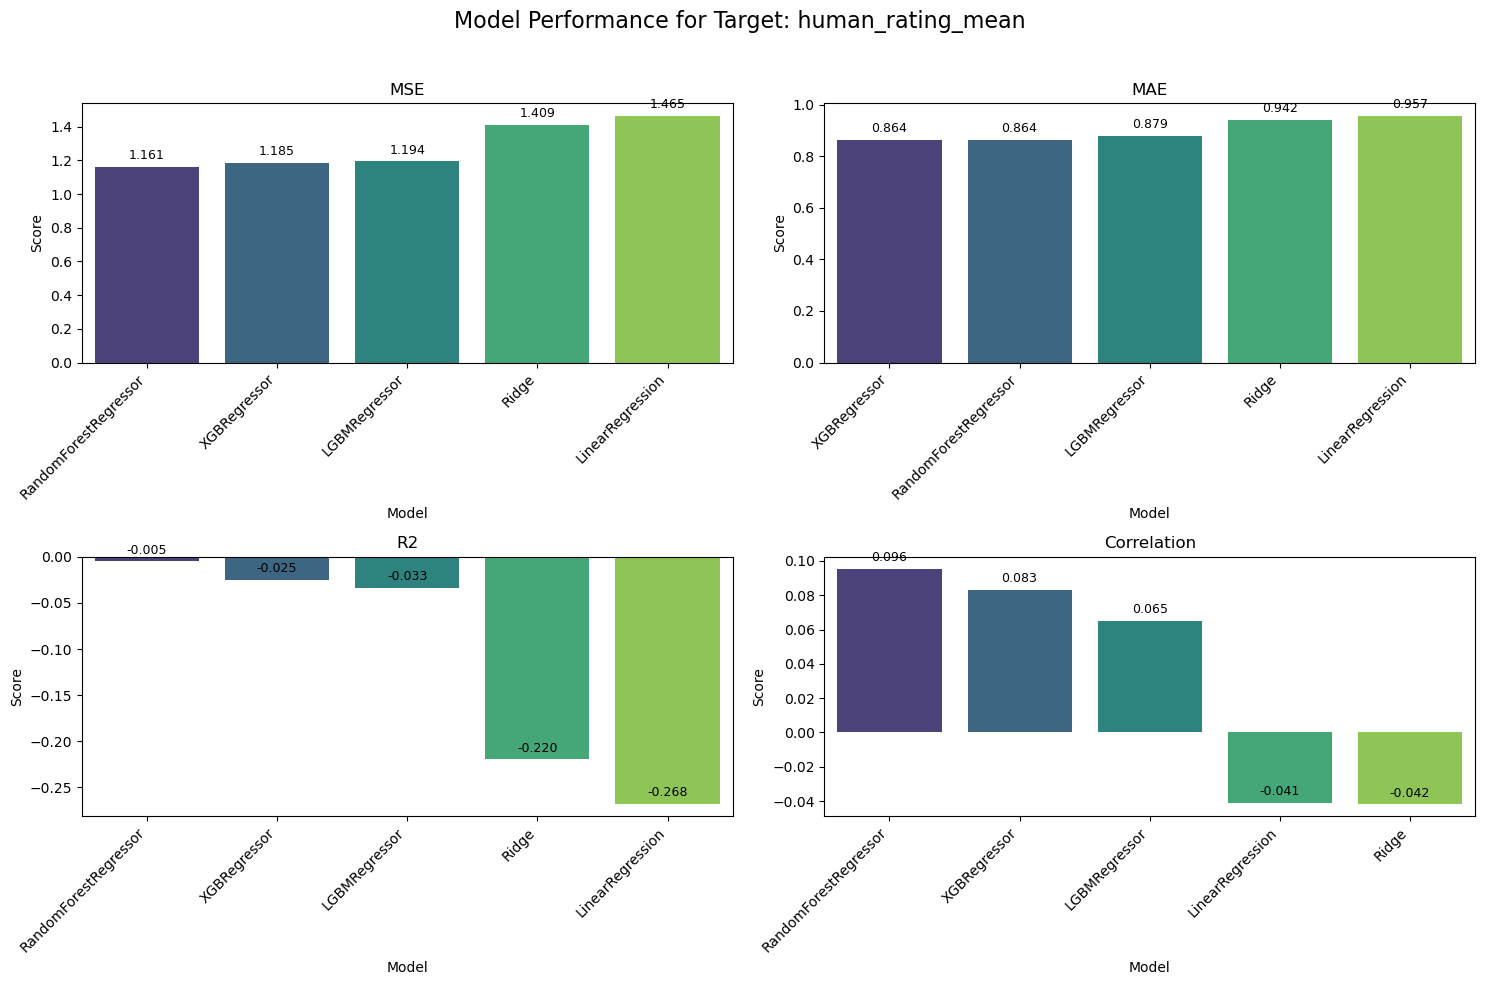

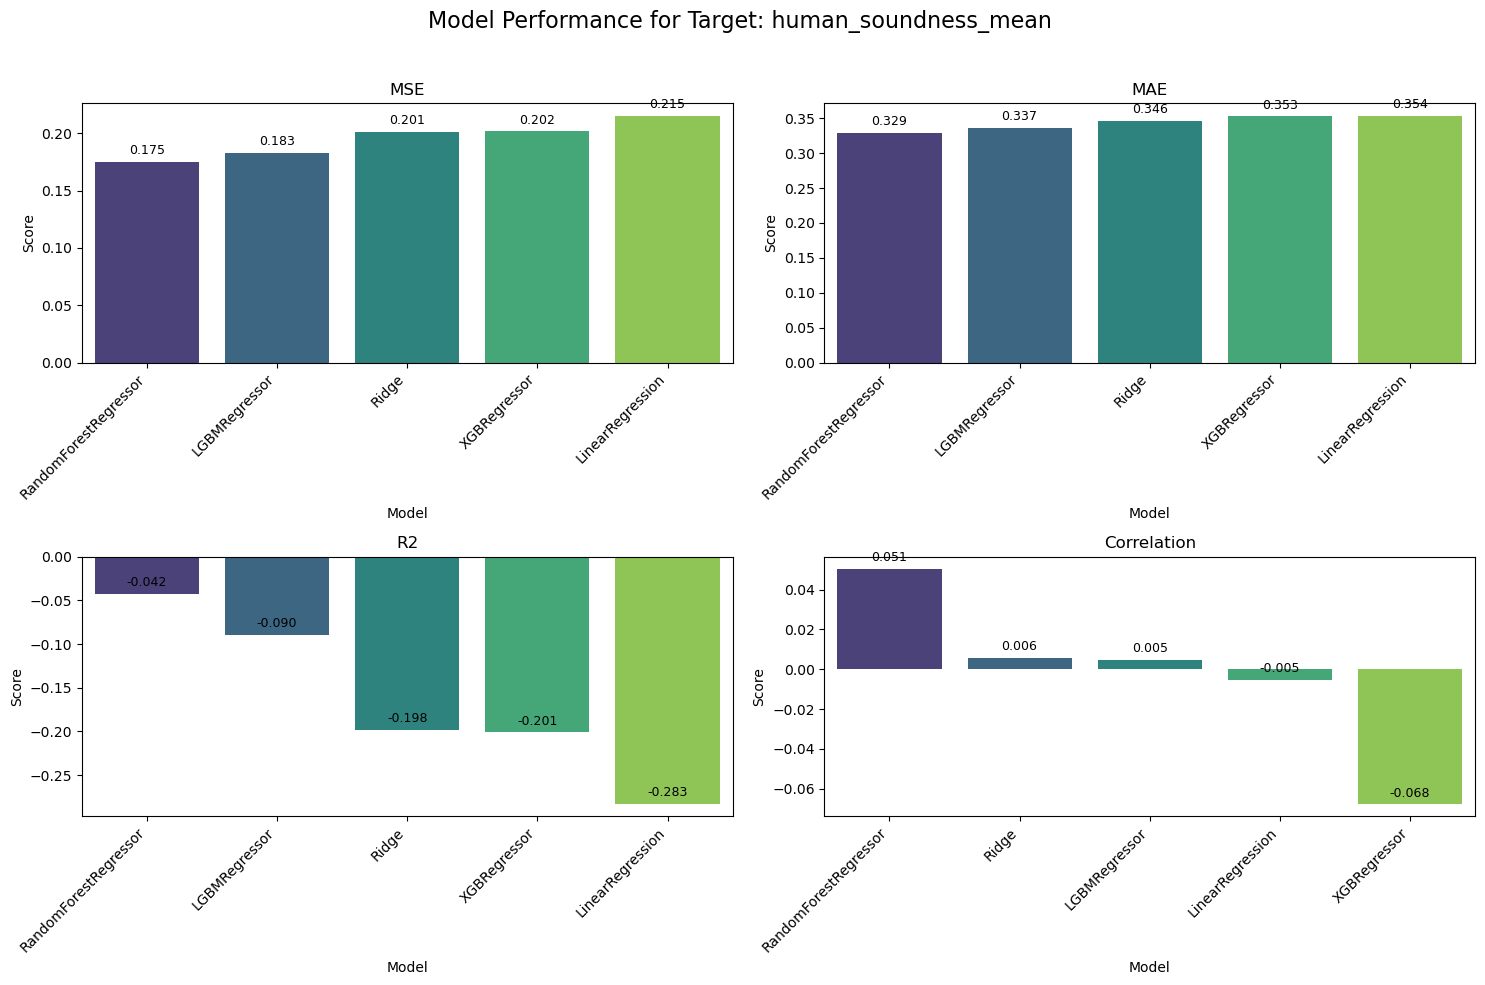

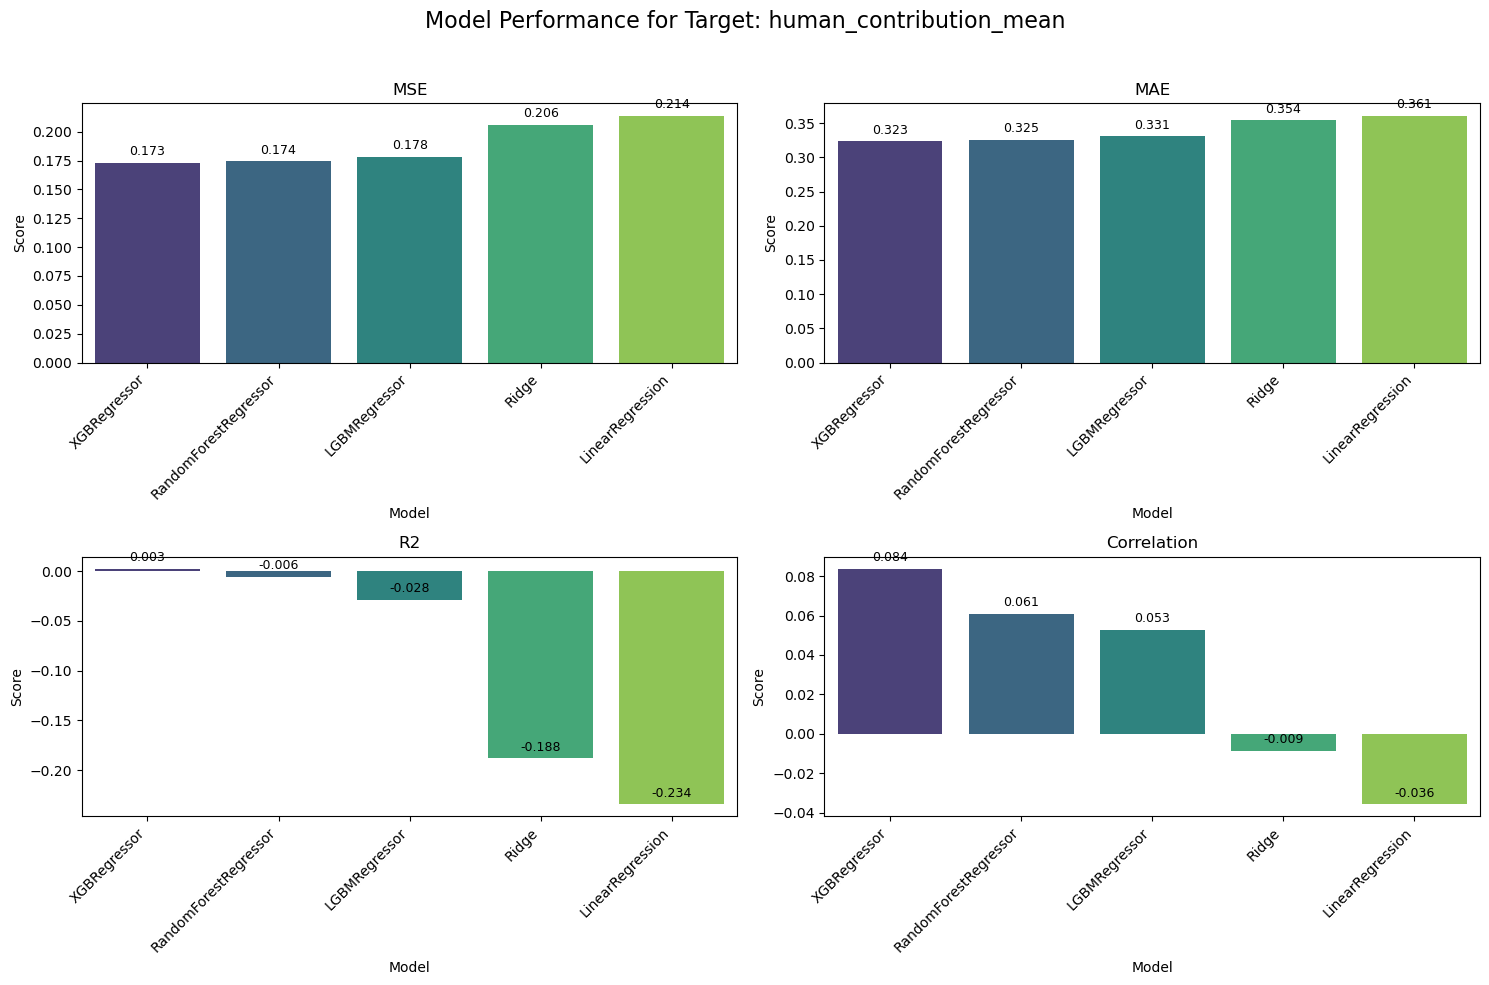

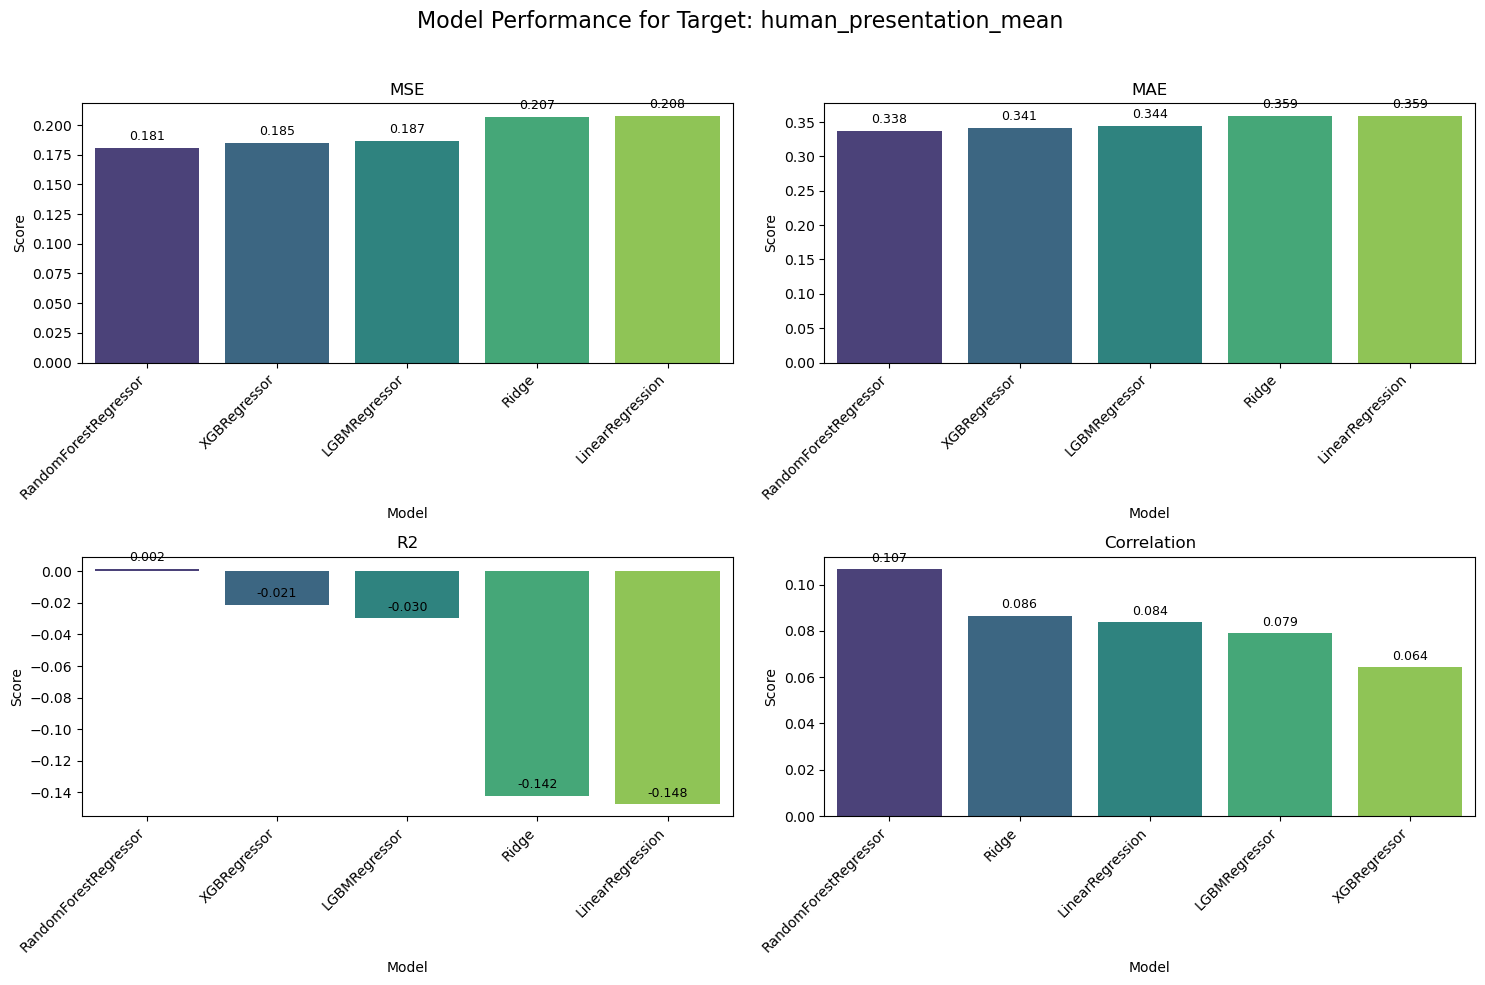

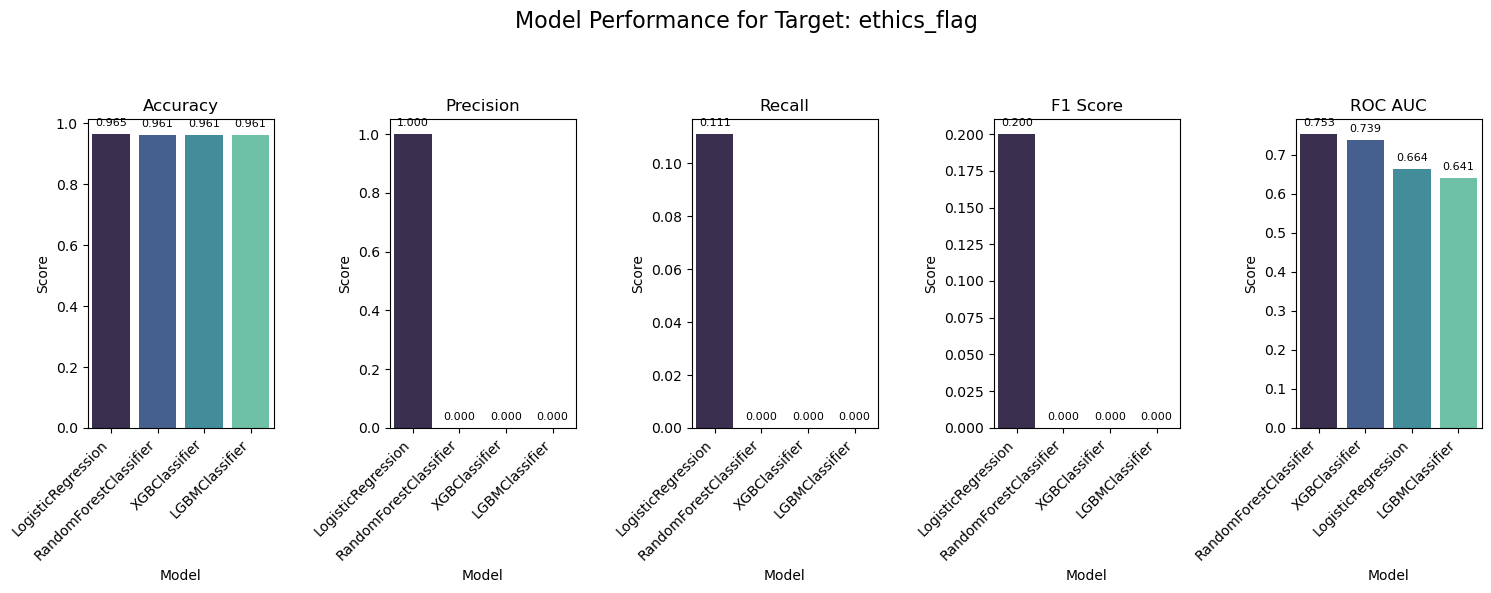

In [18]:
if results: 
    # Plotting for Regression Targets
    for target_name, model_metrics in results.items():
        if target_name == target_col_classification: 
            continue
        
        df_metrics = pd.DataFrame(model_metrics).T 
        
        expected_reg_metrics = ["MSE", "MAE", "R2", "Correlation"]
        for metric in expected_reg_metrics:
            if metric not in df_metrics.columns:
                df_metrics[metric] = np.nan
        df_metrics = df_metrics[expected_reg_metrics] 

        if df_metrics.empty:
            print(f"No metrics to plot for regression target: {target_name}")
            continue

        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Model Performance for Target: {target_name}", fontsize=16)
        
        metrics_to_plot_reg = ["MSE", "MAE", "R2", "Correlation"]
        for i, metric in enumerate(metrics_to_plot_reg):
            plt.subplot(2, 2, i + 1)
            sorted_df = df_metrics[metric].dropna().sort_values(ascending=(metric in ["MSE", "MAE"]))
            
            if not sorted_df.empty:
                bars = sns.barplot(x=sorted_df.index, y=sorted_df.values, palette="viridis")
                plt.title(metric)
                plt.ylabel("Score")
                plt.xlabel("Model")
                plt.xticks(rotation=45, ha="right")
                for bar in bars.patches:
                    bars.annotate(format(bar.get_height(), '.3f'),
                                   (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',
                                   size=9, xytext=(0, 8),
                                   textcoords='offset points')
            else:
                plt.title(f"{metric} (No data)")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # Plotting for Classification Target (ethics_flag)
    if target_col_classification in results:
        clf_metrics_data = results[target_col_classification]
        df_clf_metrics = pd.DataFrame(clf_metrics_data).T
        
        expected_clf_metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
        for metric in expected_clf_metrics:
            if metric not in df_clf_metrics.columns:
                df_clf_metrics[metric] = np.nan
        df_clf_metrics = df_clf_metrics[expected_clf_metrics]

        if not df_clf_metrics.empty:
            plt.figure(figsize=(15, 6)) 
            plt.suptitle(f"Model Performance for Target: {target_col_classification}", fontsize=16)
            
            metrics_to_plot_clf = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
            num_clf_metrics = len(metrics_to_plot_clf)
            
            for i, metric in enumerate(metrics_to_plot_clf):
                plt.subplot(1, num_clf_metrics, i + 1) 
                sorted_df_clf = df_clf_metrics[metric].dropna().sort_values(ascending=False) 
                
                if not sorted_df_clf.empty:
                    bars_clf = sns.barplot(x=sorted_df_clf.index, y=sorted_df_clf.values, palette="mako")
                    plt.title(metric)
                    plt.ylabel("Score")
                    plt.xlabel("Model")
                    plt.xticks(rotation=45, ha="right")
                    for bar in bars_clf.patches:
                        bars_clf.annotate(format(bar.get_height(), '.3f') if not np.isnan(bar.get_height()) else 'N/A',
                                       (bar.get_x() + bar.get_width() / 2,
                                        bar.get_height()), ha='center', va='center',
                                       size=8, xytext=(0, 8),
                                       textcoords='offset points')
                else:
                    plt.title(f"{metric} (No data)")
            plt.tight_layout(rect=[0, 0, 1, 0.92])
            plt.show()
        else:
            print(f"No metrics to plot for classification target: {target_col_classification}")
else:
    print("No results to plot.")

## Feature Importance Plotting

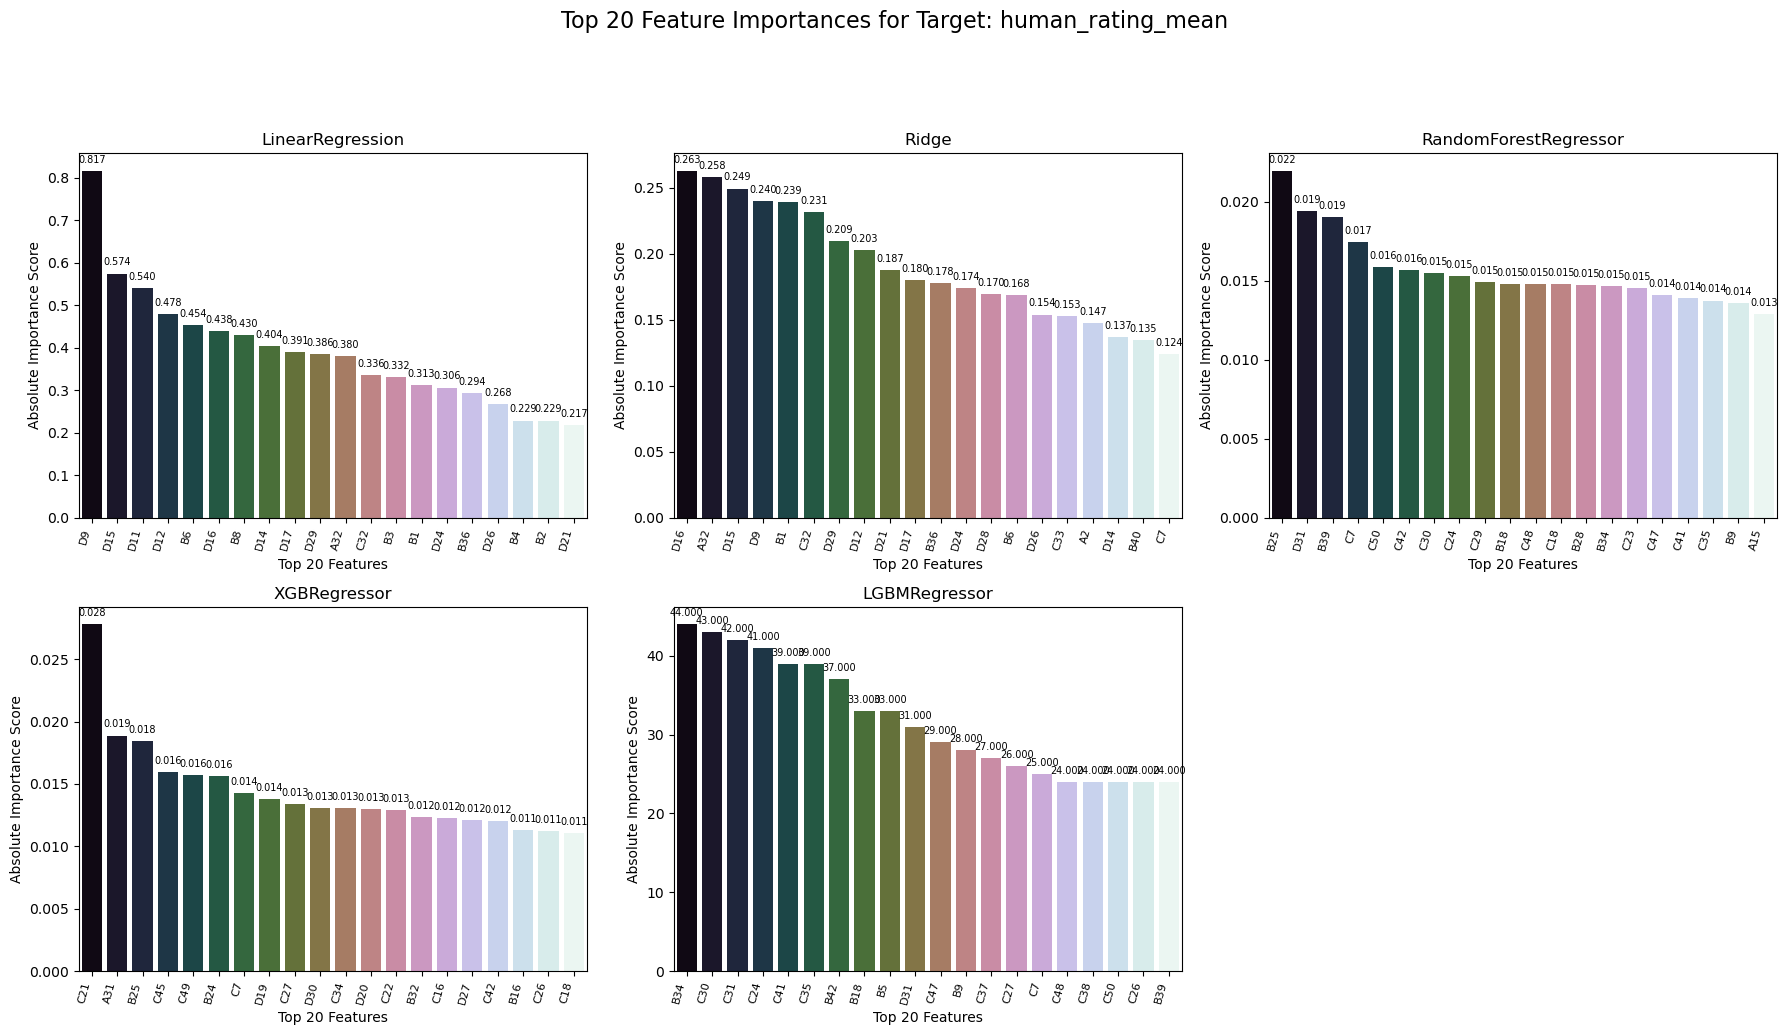

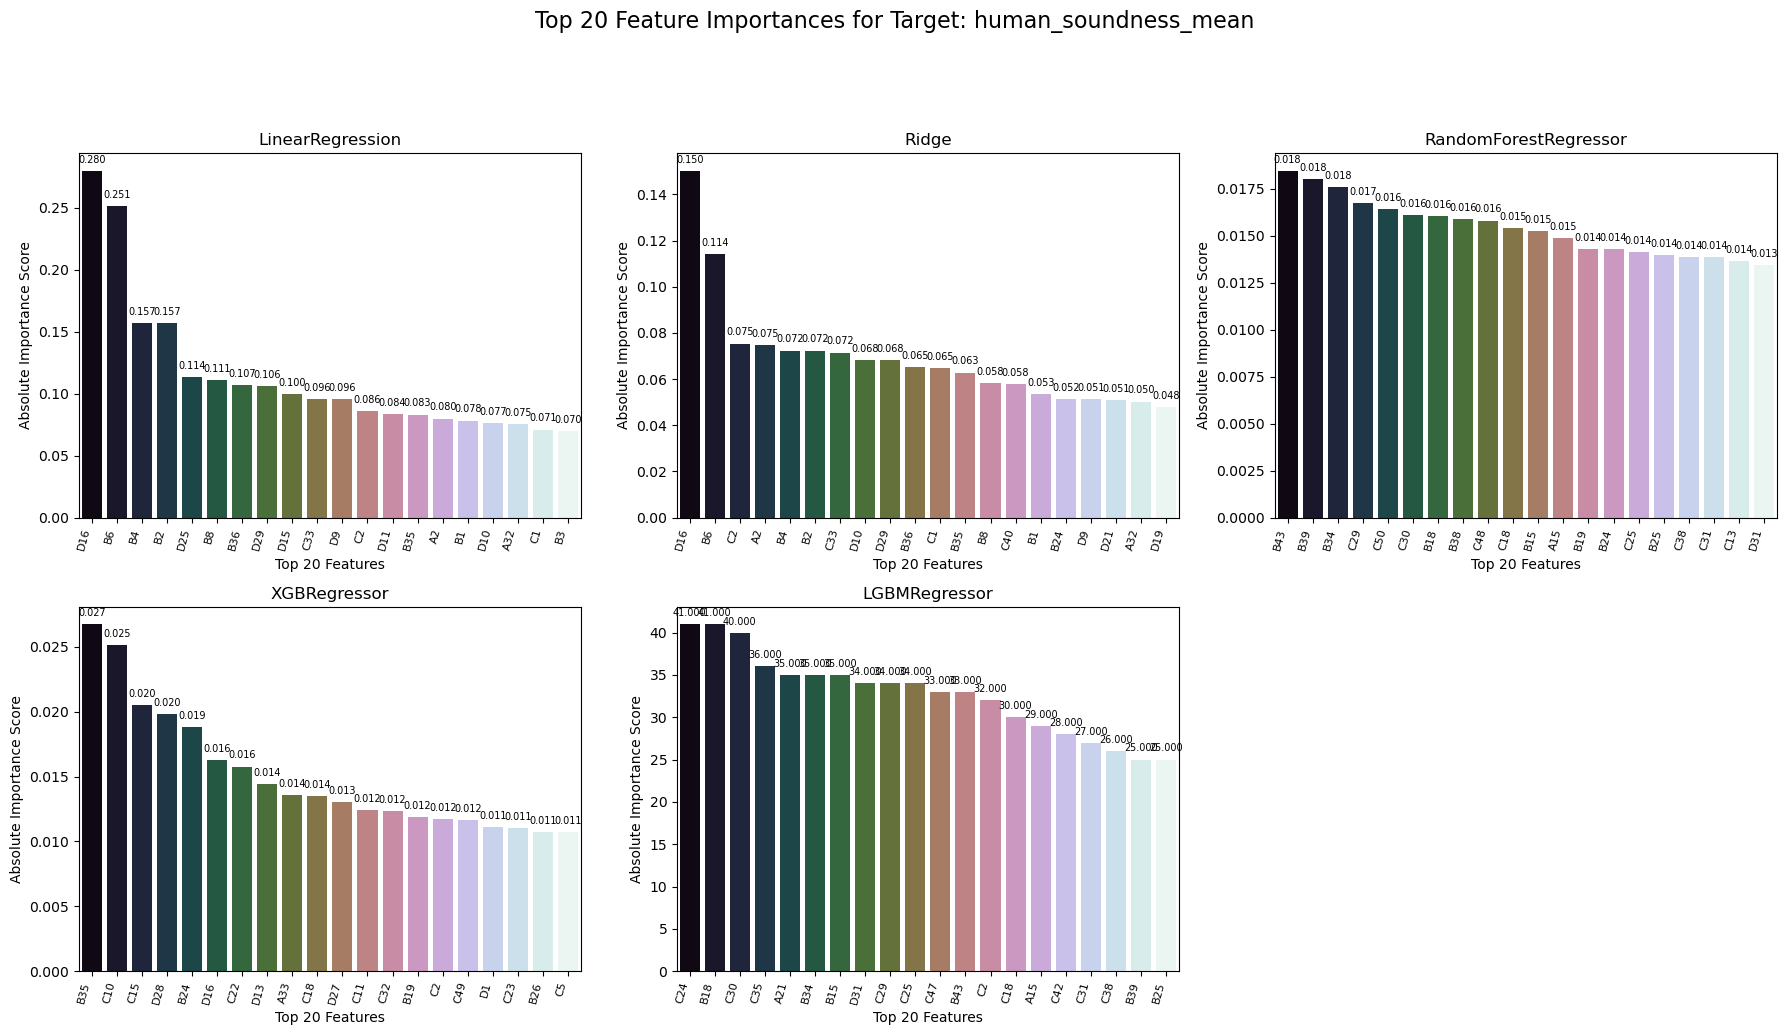

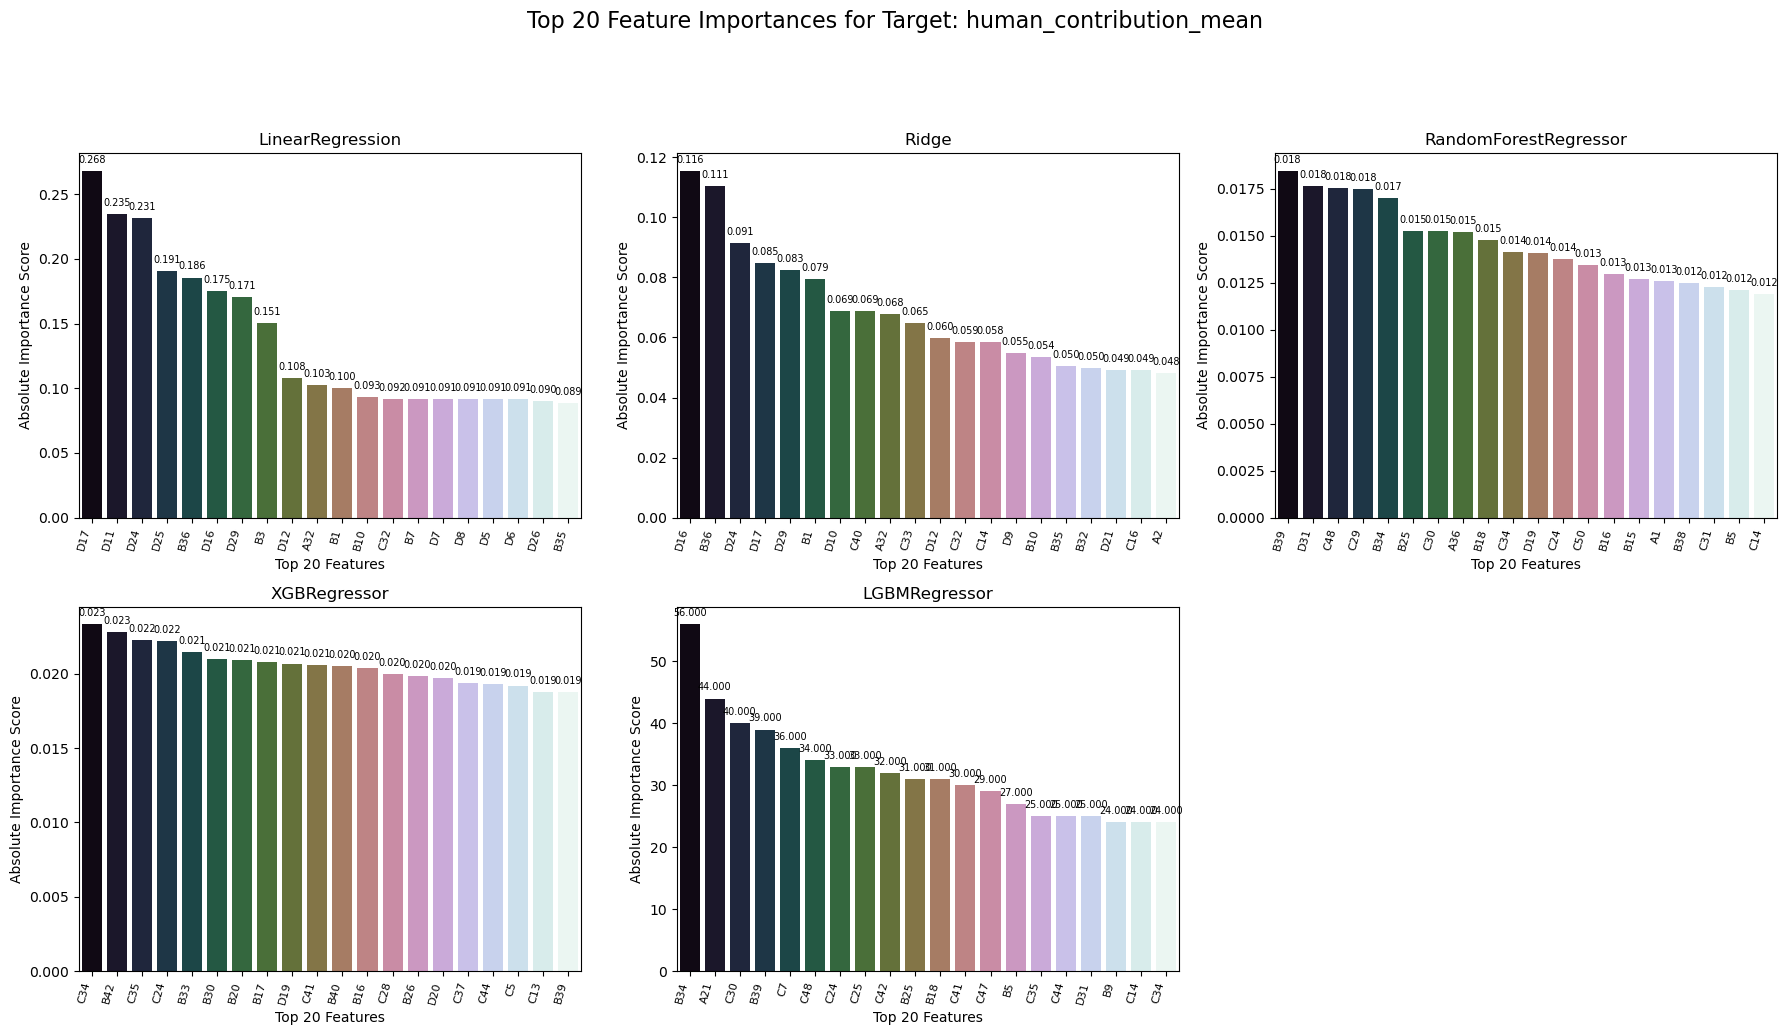

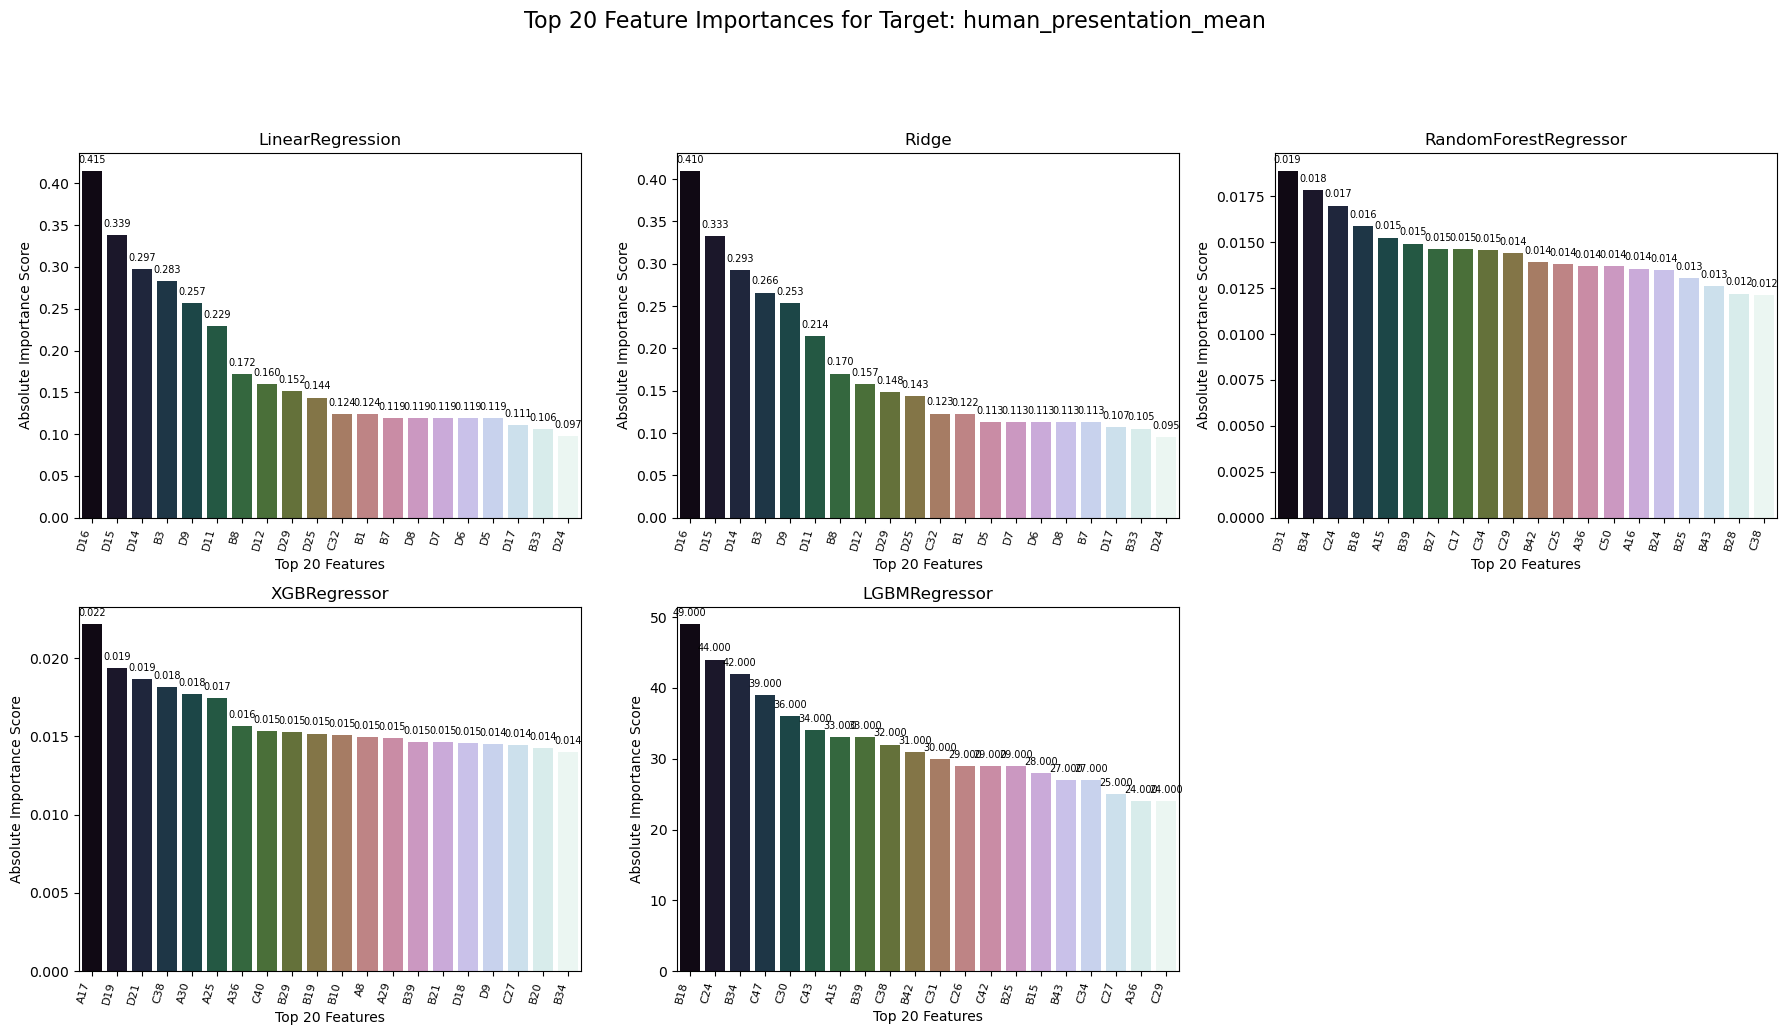

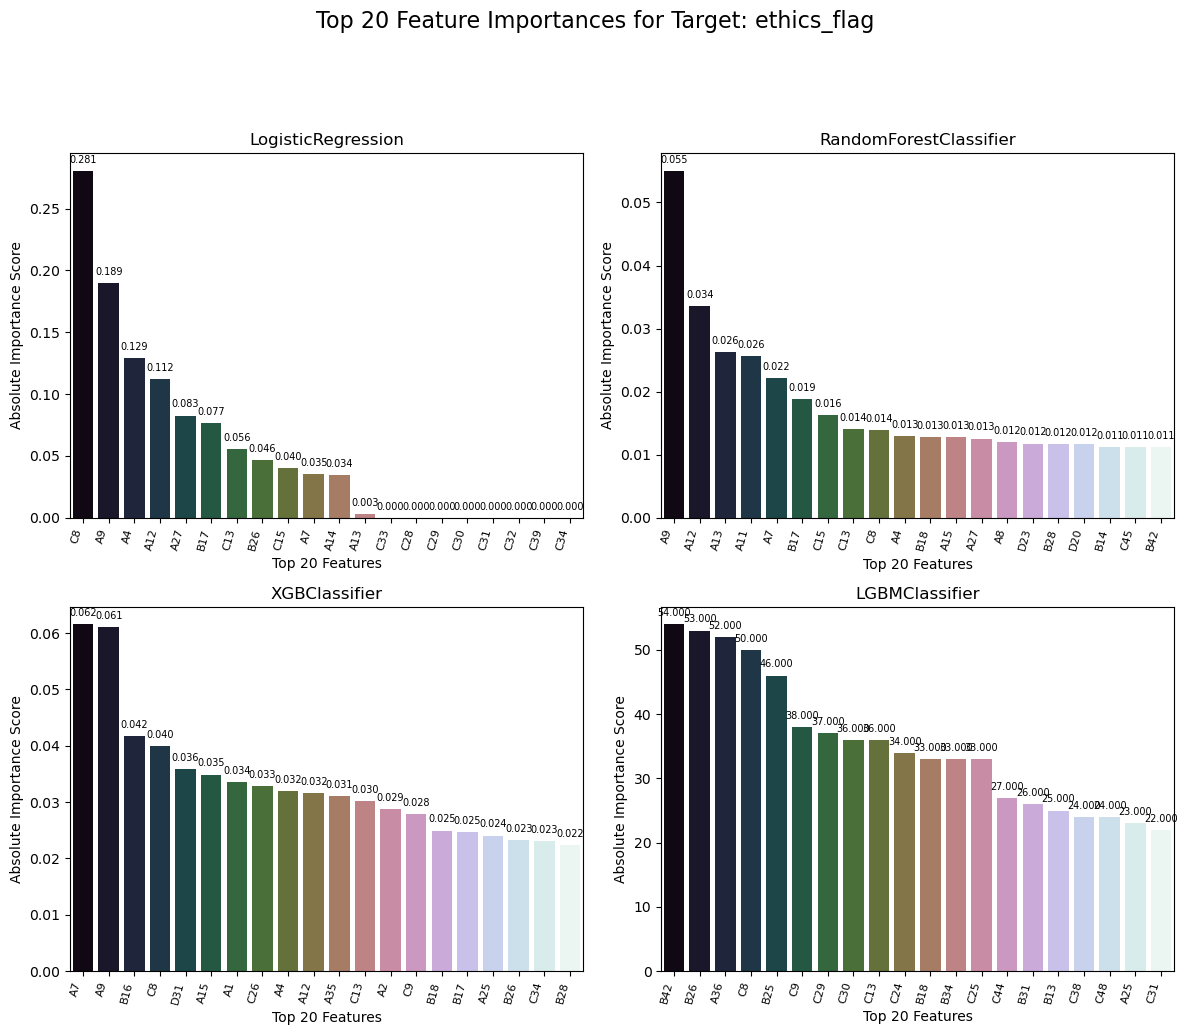

In [19]:
# FEATURE_NAMES_FOR_PLOTTING is now ALL_FEATURE_ITEM_IDS from Cell 1
if feature_importances_results and not X_train.empty: 
    num_total_features = X_train.shape[1] # Should be len(ALL_FEATURE_ITEM_IDS)
    
    for target_name, model_importances_dict in feature_importances_results.items():
        if not model_importances_dict: 
            print(f"No feature importances recorded for target: {target_name}")
            continue

        num_models = len(model_importances_dict)
        if num_models == 0:
            continue

        cols_subplot = int(np.ceil(np.sqrt(num_models)))
        rows_subplot = int(np.ceil(num_models / cols_subplot))
        
        plt.figure(figsize=(6 * cols_subplot, 5 * rows_subplot)) 
        plt.suptitle(f"Top 20 Feature Importances for Target: {target_name}", fontsize=16, y=1.03)

        model_idx = 0
        for model_name, importances_array in model_importances_dict.items():
            # Ensure importances_array is a 1D array of the correct length
            if importances_array is None:
                print(f"Importances are None for {model_name} on target {target_name}.")
                continue
            
            # Handle cases where importances might be nested (e.g. LogisticRegression coef_ for multiclass)
            # Or if it's already 1D from .feature_importances_
            if isinstance(importances_array, np.ndarray) and importances_array.ndim > 1:
                # For multi-class Logistic Regression, coef_ can be (n_classes, n_features)
                # For binary, it's often (1, n_features), so take the first row.
                # A common approach for multi-class is to average absolute importances across classes or pick one.
                # Here, if it's 2D, we assume it might be (1, n_features) or needs averaging for magnitude.
                plot_importances_flat = np.abs(importances_array).mean(axis=0) if importances_array.shape[0] > 1 else np.abs(importances_array.flatten())
            else:
                plot_importances_flat = np.abs(np.array(importances_array).flatten())


            if len(plot_importances_flat) != num_total_features:
                print(f"Skipping feature importance for {model_name} on target {target_name} due to mismatched importances length. Expected {num_total_features}, got {len(plot_importances_flat)}.")
                continue
            
            model_idx += 1
            plt.subplot(rows_subplot, cols_subplot, model_idx)
            
            # FEATURE_NAMES_FOR_PLOTTING is ALL_FEATURE_ITEM_IDS
            if len(plot_importances_flat) != len(FEATURE_NAMES_FOR_PLOTTING):
                # This case should be rare now if X.columns and FEATURE_NAMES_FOR_PLOTTING are aligned
                current_feature_names = X_train.columns # Fallback to actual column names from X_train
                print(f"Warning: Mismatch between plot_importances_flat length ({len(plot_importances_flat)}) and FEATURE_NAMES_FOR_PLOTTING length ({len(FEATURE_NAMES_FOR_PLOTTING)}) for {model_name} on {target_name}. Using X_train.columns.")
                if len(plot_importances_flat) != len(current_feature_names):
                    print(f"Critical Error: Mismatch even with X_train.columns for {model_name}. Skipping plot.")
                    plt.title(f"{model_name} (Import. Length Error)")
                    continue # Skip this subplot
            else:
                current_feature_names = FEATURE_NAMES_FOR_PLOTTING
            
            importance_series = pd.Series(plot_importances_flat, index=current_feature_names)
            # Select top N features for plotting, e.g., top 20
            top_n = 20
            sorted_importances = importance_series.sort_values(ascending=False).head(top_n)
            
            if not sorted_importances.empty:
                bars = sns.barplot(x=sorted_importances.index, y=sorted_importances.values, palette="cubehelix")
                plt.title(f"{model_name}")
                plt.ylabel("Absolute Importance Score")
                plt.xlabel(f"Top {top_n} Features")
                plt.xticks(rotation=75, ha="right", fontsize=8) # Rotate more for long feature names
                for bar in bars.patches:
                    bars.annotate(format(bar.get_height(), '.3f'),
                                   (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',
                                   size=7, xytext=(0, 8),
                                   textcoords='offset points')
            else:
                plt.title(f"{model_name} (No importances)")

        plt.tight_layout(rect=[0, 0, 1, 0.96]) 
        plt.show()
else:
    print("No feature importances to plot or X_train is empty.")
